In [1]:
%pip install mujoco
%pip install scipy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Import packages

In [2]:
# Core imports
from typing import Callable, Optional, Union, List
import math
import time

# MuJoCo env packages
import os
import subprocess
import sys

from IPython.display import clear_output
import mediapy as media
import mujoco

# solver, plot packages
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
import numpy.typing as npt

# MacOS setting for hardware acceleration

In [3]:
def setup_macos_environment() -> None:
    # Set environment variable to use software rendering with MuJoCo
    print(">> Setting environment variable to use OpenGL rendering:")
    os.environ["MUJOCO_GL"] = "glfw"

    try:
        print("Checking that the installation succeeded:")
        mujoco.MjModel.from_xml_string("<mujoco/>")
    except Exception as e:
        raise RuntimeError(
            "Something went wrong during installation. Check the error message below for more information."
        ) from e

    print(">> Installation successful.")

    def install_ffmpeg_and_mediapy():
        try:
            subprocess.run(["ffmpeg", "-version"], check=True)
        except (subprocess.CalledProcessError, FileNotFoundError):
            print(">> Installing ffmpeg:")
            subprocess.run(["brew", "install", "ffmpeg"], check=True)

        print(">> Installing mediapy:")
        subprocess.run([sys.executable, "-m", "pip", "install", "mediapy"], check=True)

    install_ffmpeg_and_mediapy()

    # More legible printing from numpy
    np.set_printoptions(precision=3, suppress=True, linewidth=100)
    clear_output()
    print(">> Setup complete.")


def setup_colab_environment() -> None:
    if subprocess.run("nvidia-smi").returncode:
        raise RuntimeError(
            "Cannot communicate with GPU. "
            "Make sure you are using a GPU Colab runtime. "
            "Go to the Runtime menu and select Choose runtime type."
        )

    # Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
    # This is usually installed as part of an Nvidia driver package, but the Colab
    # kernel doesn't install its driver via APT, and as a result the ICD is missing.
    # (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
    NVIDIA_ICD_CONFIG_PATH = "/usr/share/glvnd/egl_vendor.d/10_nvidia.json"
    if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
        with open(NVIDIA_ICD_CONFIG_PATH, "w") as f:
            f.write("""{
        "file_format_version" : "1.0.0",
        "ICD" : {
            "library_path" : "libEGL_nvidia.so.0"
        }
    }
    """)

    # Configure MuJoCo to use the EGL rendering backend (requires GPU)
    print("Setting environment variable to use GPU rendering:")
    %env MUJOCO_GL=egl

    # Check if installation was successful.
    try:
        print("Checking that the installation succeeded:")
        mujoco.MjModel.from_xml_string("<mujoco/>")
    except Exception as e:
        raise e from RuntimeError(
            "Something went wrong during installation. Check the shell output above "
            "for more information.\n"
            "If using a hosted Colab runtime, make sure you enable GPU acceleration "
            'by going to the Runtime menu and selecting "Choose runtime type".'
        )

    print("Installation successful.")

    # Graphics and plotting.
    print("Installing mediapy:")
    !command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
    !pip install -q mediapy

    # More legible printing from numpy.
    np.set_printoptions(precision=3, suppress=True, linewidth=100)

    clear_output()

In [4]:
if sys.platform == "darwin":
    setup_macos_environment()
else:
    setup_colab_environment()

>> Setup complete.


# `MuJoCo`: An Advanced Physics Engine

- `MuJoCo`, which stands for Multi-Joint dynamics with Contact, is a cutting-edge physics engine designed to aid in research and development in various fields, including robotics, biomechanics, graphics, and animation.

- It is renowned for its speed, accuracy, and powerful modeling capabilities, making it a valuable tool for both academic and practical applications.

## Setup the `MuJoCo` environment for simulating and visualizing a Panda robot model.

### `XML` 
- `model` => Used to instantiate an `MjModel`.
- Create an `MjData` which holds the simulation state, and an instance of the `Renderer` class defined above.

### `model` = `mujoco.MjModel`.`from_xml_string(xml)`
- XML로부터 mujoco model을 생성함.
-  **physical properties** -> `kinematics`, and `dynamics`, `Inertia`, `stiffness`, ... of the Panda robot

### `mujoco.MjData(model)`
- Initializes `MuJoCo data object` associated with the model.
- Contains `simulation state`, including `positions`, `velocities`, `forces`, and other dynamic properties.

### `mujoco.Renderer(model)`:
- Initializes the renderer object for visualizing the MuJoCo model.
- Handle the rendering of the model's simulation in a 3D graphical window.

In [5]:
# Clone the repository containing the Panda robot model and related assets
!git clone https://github.com/SouthColumn76/panda_mjcf

# Copy the assets directory from the cloned repository to the current working directory
!cp -r panda_mjcf/assets ./assets

# Open and read the XML file defining the Panda robot model
MODEL_FILE = "panda_mjcf/panda.xml"

with open(MODEL_FILE, "r") as fp:
    model_xml = fp.read()

fatal: destination path 'panda_mjcf' already exists and is not an empty directory.


## Initialize `Mujoco` Model

In [6]:
# 1. Model은 Mujoco의 물리 객체 모델
model = mujoco.MjModel.from_xml_string(model_xml)

# 2. Data는 Model의 physical state를 나타내는 객체
data = mujoco.MjData(model)

# 3. Renderer는 Model을 3D 렌더링하는 객체
renderer = mujoco.Renderer(model)

The state in the `data` object is in the default configuration. Let's invoke the forward dynamics to populate all the derived quantities (like the positions of geoms in the world), update the scene and render it:

### `mujoco`.`mj_forward(model, data)` `-> None`
- computes the **forward dynamics** of the model.
- **updates the state** of the simulation based on the current `positions`, `velocities`, and `forces` acting on the model.
- Advances the simulation **by one time step**, considering the physics and constraints defined in the model.
- Call by reference를 사용함, model, data를 직접 수정함. 

> `mj_forward`를 호출하면 다음 `time_step`에서의 모델 forward kinematics를 계산함

### `renderer`.`update_scene(data)`
- Updates the renderer with the latest simulation data.
- Prepares the scene for rendering by incorporating the current state of the simulation (positions, orientations, etc.) into the graphical representation.

### `renderer`.`render()`:
- Renders the current scene, generating an `image` based on the updated simulation data.
- Produces a visual representation of the model and its environment as defined by the current state.
> 현재 model의 상태 `Image`를 return함

### `media`.`show_image(renderer.render() = Image)`: 
- Displays the rendered image using a media display tool. 
- Takes the image produced by `renderer.render()`
- Shows it in an appropriate viewer, **making the simulation's visual output accessible to the user.**

""

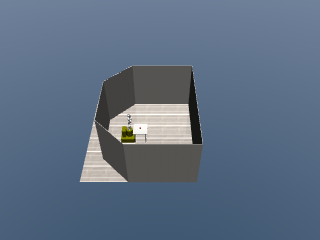

In [7]:
# Perform a forward dynamics computation to update the simulation state
mujoco.mj_forward(model, data)

# Update the renderer with the current simulation data
renderer.update_scene(data)

# Render the current scene and display the resulting image
media.show_image(renderer.render())

# -------> panda.xml을 수정하면, camera를 추가할 수 있다.

## Check camera of `XML` model

Because it is far away, the robot cannot be seen in detail.

`Mujoco` **can use multiple cameras**.

Check the cameras currently in this XML and render using each one.

frontview


""

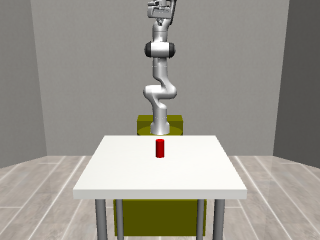

birdview


""

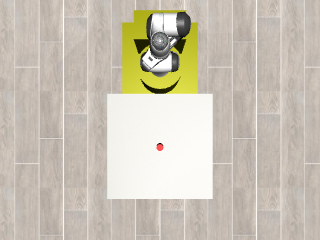

agentview


""

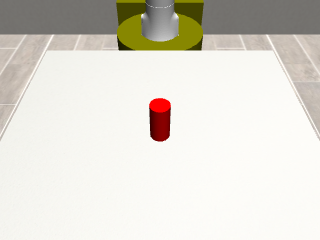

sideview


""

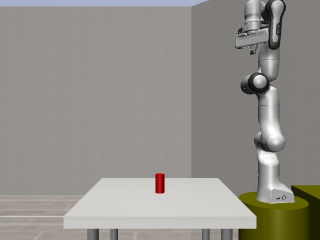

targetview


""

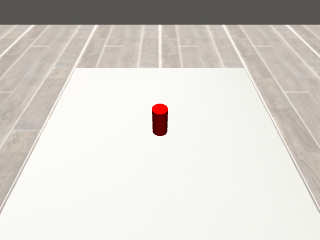

In [8]:
# Mujoco의 model camera 체킹

for i in range(model.ncam):
    print(model.camera(i).name)
    renderer.update_scene(data, camera=i)
    media.show_image(renderer.render())

When specifying a camera, we can use not only the number but also the name.

""

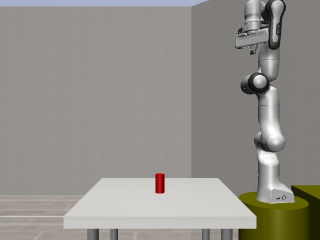

In [9]:
renderer.update_scene(data, camera="sideview")
media.show_image(renderer.render())

## Actuator Control

### `mj_resetDataKeyframe` can be used to load them. Let's see what they look like:

1. `Keyframes`: **predefined states of the model**
2. `Model`: comes with some built-in `Keyframes` which are saved simulation states.

### `mujoco`.`mj_resetDataKeyframe(model, data, key)`
- Resets simulation data: **to match the state defined by the specified `Keyframe`**.
- Sets the simulation to these states: one by one, as the loop iterates.

""

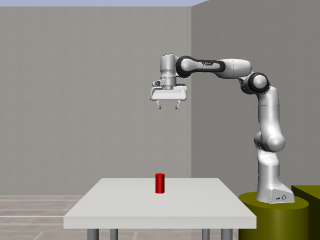

In [10]:
for key in range(model.nkey):
    mujoco.mj_resetDataKeyframe(model, data, key)
    mujoco.mj_forward(model, data)
    renderer.update_scene(data, camera="sideview")
    media.show_image(renderer.render())

Now let's simulate the physics and render to make a video.

In [11]:
DURATION = 3  # seconds
FRAMERATE = 60  # Hz

# Initialize pose.
mujoco.mj_resetDataKeyframe(model, data, 0)

frames = []
while data.time < DURATION:
    # Step the simulation.
    mujoco.mj_step(model, data)

    # Render and save frames.
    if len(frames) < data.time * FRAMERATE:
        renderer.update_scene(data, camera="sideview")
        pixels = renderer.render()
        frames.append(pixels)

# Display video.
media.show_video(frames, fps=FRAMERATE)

Since the model is defined as built-in torque actuators, without control, the posture cannot be maintained due to gravity.

we can use to drive the robot's joints by setting the `data.ctrl` vector.

## Find the relationship between `joint` and `actuator`

In `XML`, not only robots but all movable objects have joints.

Among them, the only `joints` that **can be controlled are those connected to the `actuator`**.

To find out which joints an actuator can control, **check the actuator's `transmission type` and `ID`**.

In [12]:
model.actuator(0).trntype, model.actuator(0).trnid

(array([0], dtype=int32), array([ 1, -1], dtype=int32))

### In this `XML`

1. `mjTRN_JOINT`: transmission type of each joint of the robot
2. `mjTRN_TENDON`: the finger of the end-effector

In [13]:
mujoco.mjtTrn.mjTRN_JOINT, mujoco.mjtTrn.mjTRN_TENDON

(<mjtTrn.mjTRN_JOINT: 0>, <mjtTrn.mjTRN_TENDON: 3>)

# Problem 1. Designing PID Controller

Implement a PID (Proportional-Integral-Derivative) Controller class in Python to control a system. The PID controller should be capable of updating its control output based on the current state of the system, the target state, and the elapsed time. The controller should include features like anti-windup and output smoothing using Exponential Moving Average (EMA).

**Specifications**:

1. Class Definition:
  - Class Name: `PIDController`
2. Constructor Parameters:
  - `k_p`: Proportional gain (default: 0.01)
  - `k_i`: Integral gain (default: 0.0)
  - `k_d`: Derivative gain (default: 0.001)
  - `dt`: Time step (default: 0.01)
  - `dim`: Dimensionality of the controller (default: 1)
  - `dt_min`: Minimum time step to avoid division by zero (default: 1e-6)
  - `out_min`: Minimum output value (default: -infinity)
  - `out_max`: Maximum output value (default: infinity)
  - `ANTIWU`: Boolean to enable or disable anti-windup (default: True)
  - `out_alpha`: Smoothing factor for output EMA (default: 0.0)
3. Methods:
  - `reset(self, t_curr=0.0)`: Resets the internal state of the controller.
  - `update(self, x_curr, t_curr, x_trgt=None)`: Updates the controller state and computes the control output based on the current and target states and the current time.
  - `out(self)`: Returns the current control output value.
4. Functional Requirements:

  - The controller should compute the control output using the PID formula:

### $$u(t)=K_{p}e(t)+K_{i}\int e(t)dt+K_{d} \frac{de(t)}{dt}$$

  - Implement anti-windup to prevent the integral term from accumulating excessively.
  - Smooth the control output using an Exponential Moving Average (EMA) if out_alpha is greater than 0.
  - Ensure the output value is clipped within the specified out_min and out_max range.

In [14]:
class PIDController:
    def __init__(
        self,
        k_p=0.01,
        k_i=0.0,
        k_d=0.001,
        dt=0.01,
        dim=1,
        dt_min=1e-6,
        out_min=-np.inf,
        out_max=np.inf,
        ANTIWU=True,  # anti-windup
        out_alpha=0.0,  # output EMA (0: no EMA)
    ) -> None:
        # Initialize proportional gain
        self.k_p = np.ones(shape=dim) * k_p
        # Initialize integral gain
        self.k_i = np.ones(shape=dim) * k_i
        # Initialize derivative gain
        self.k_d = np.ones(shape=dim) * k_d
        # Set time step
        self.dt = dt
        # Set dimension
        self.dim = dim
        # Set minimum time step
        self.dt_min = dt_min
        # Set output minimum limit
        self.out_min = out_min
        # Set output maximum limit
        self.out_max = out_max
        # Set anti-windup flag
        self.ANTIWU = ANTIWU
        # Set output exponential moving average coefficient
        self.out_alpha = out_alpha

        # Initialize PID terms
        self.p_term = np.zeros(shape=dim)
        self.i_term = np.zeros(shape=dim)
        self.d_term = np.zeros(shape=dim)

        # Initialize buffers
        self.reset()

    def reset(self, t_curr=0.0) -> None:
        # Reset counter
        self.cnt = 0
        # Reset target state
        self.x_trgt = np.zeros(shape=self.dim)
        # Reset current state
        self.x_curr = np.zeros(shape=self.dim)
        # Reset current output
        self.out_val = np.zeros(shape=self.dim)
        # Reset previous output
        self.out_val_prev = np.zeros(shape=self.dim)
        # Set current time
        self.t_curr = t_curr
        # Set previous time
        self.t_prev = t_curr
        # Reset current error
        self.err_curr = np.zeros(shape=self.dim)
        # Reset integrated error
        self.err_intg = np.zeros(shape=self.dim)
        # Reset previous error
        self.err_prev = np.zeros(shape=self.dim)
        # Reset proportional term
        self.p_term = np.zeros(shape=self.dim)
        # Reset derivative term
        self.d_term = np.zeros(shape=self.dim)
        # Reset error output
        self.err_out = np.zeros(shape=self.dim)

    def update(self, x_curr, t_curr, x_trgt=None) -> None:
        """
        Update PID controller
        u(t) = K_p e(t) + K_i int e(t) {dt} + K_d {de}/{dt}
        """
        # Update target state if provided
        if x_trgt is not None:
            self.x_trgt = x_trgt
        # Update current time if provided
        if t_curr is not None:
            self.t_curr = t_curr
        # Update current state if provided
        if x_curr is not None:
            self.x_curr = x_curr
            # PID controller updates
            self.dt = max(self.dt_min, self.t_curr - self.t_prev)
            # Compute current error
            self.err_curr = self.x_trgt - self.x_curr
            self.err_intg = self.err_intg + (self.err_curr * self.dt)
            self.err_diff = self.err_curr - self.err_prev

            # Apply anti-windup if enabled
            if self.ANTIWU:
                self.err_out = self.err_curr * self.out_val
                self.err_intg[self.err_out < 0.0] = 0.0

            # Compute PID terms if time step is valid
            if self.dt > self.dt_min:
                self.p_term = self.k_p * self.err_curr
                self.i_term = self.k_i * self.err_intg
                self.d_term = self.k_d * (self.err_diff / self.dt)
                self.out_val = np.clip(
                    a=self.p_term + self.i_term + self.d_term,
                    a_min=self.out_min,
                    a_max=self.out_max,
                )
                # Smooth the output control value using EMA
                self.out_val = (
                    self.out_alpha * self.out_val_prev
                    + (1.0 - self.out_alpha) * self.out_val
                )
                # Update previous output
                self.out_val_prev = self.out_val

            # Backup current time and error for next iteration
            self.t_prev = self.t_curr
            self.err_prev = self.err_curr

        # Increment counter if time and current state are provided
        if (t_curr is not None) and (x_curr is not None):
            self.cnt = self.cnt + 1

    def out(self) -> npt.NDArray:
        # Return current output value
        return self.out_val

### Current status of robot `joints` required to use the `PID controller` can be known through `data.qpos`.

### `data.qpos`: **state vector** of all joints in `XML`

> need to find the `qpos` of the joints connected to the actuator.

In [15]:
model.nu  # number of actuators/controls = dim(ctrl)

joint_ids = []
ctrl_adrs = []

for actuator_id in range(model.nu):
    transmission_type = model.actuator(actuator_id).trntype[0]
    is_joint = transmission_type == mujoco.mjtTrn.mjTRN_JOINT

    if is_joint:
        model_joint = model.actuator(actuator_id)
        model_joint_id = model_joint.trnid[0]

        joint_ids.append(model_joint_id)
        ctrl_adrs.append(actuator_id)

qpos_adrs = model.jnt_qposadr[joint_ids]

In [16]:
DURATION = 10  # seconds
FRAMERATE = 60  # Hz

# Initialize pose.
mujoco.mj_resetDataKeyframe(model, data, 0)

# Initialize PID Controller
PID = PIDController(
    k_p=1000,
    k_i=0.1,
    k_d=50,
    dim=7,
    out_min=model.actuator_ctrlrange[ctrl_adrs, 0],
    out_max=model.actuator_ctrlrange[ctrl_adrs, 1],
)
PID.x_trgt = data.qpos[qpos_adrs].copy()

frames = []

while data.time < DURATION:
    # Step the simulation.
    x_curr = data.qpos[qpos_adrs].copy()

    # Calculate the control
    PID.update(x_curr, data.time)

    # Control the robot
    data.ctrl[ctrl_adrs] = PID.out()

    # Update robot state and simulate
    mujoco.mj_step(model, data)

    # Render and save frames for video
    if len(frames) < data.time * FRAMERATE:
        renderer.update_scene(data, camera="sideview")
        pixels = renderer.render()
        frames.append(pixels)

# Display video.
media.show_video(frames, fps=FRAMERATE)

# Path Planning

### Generate trajectory (`S` - `[0,1]`)

#### Robot `body` & `joint` are important in kinematics.
#### Like actuators, `bodies` also **have a relationship with `joints`**.

In [17]:
body_id = model.body("link1").id

joint_id = model.body_jntadr[body_id]

Since `mujoco` **represent the relationship** between each `body` as a `kinematic tree`

we can easily find the entire `body` and `joint` using the `body id` or `name` of the end-effector.

In [18]:
for body_id in range(model.nbody):
    print(f"body_id: {model.body(body_id).name}")

body_id: world
body_id: table
body_id: object
body_id: robot_fixed
body_id: mount_base
body_id: mount0_controller_box
body_id: mount_pedestal_feet
body_id: mount_torso
body_id: mount_pedestal
body_id: link0
body_id: link1
body_id: link2
body_id: link3
body_id: link4
body_id: link5
body_id: link6
body_id: link7
body_id: hand
body_id: left_finger
body_id: right_finger


### Some utility functions

In [19]:
def get_body_ids(model: mujoco.MjModel, eef: str | int) -> list[int]:
    eef_id = model.body(eef).id
    body_ids = [eef_id]
    body_id = eef_id
    tree_id = model.body_treeid[eef_id]

    for _ in range(model.nbody):
        parent_id = model.body(body_id).parentid[0]
        if model.body_treeid[parent_id] == tree_id:
            body_ids.append(parent_id)
            body_id = body_ids[-1]
        else:
            break
    else:
        raise ValueError(f"body {eef_id} not in tree of kinematics chain.")
    body_ids.reverse()
    return body_ids


def get_qpos_adrs(model: mujoco.MjModel, body_ids: list[int]) -> list[int]:
    jnt_ids = model.body_jntadr[body_ids]
    jnt_ids = [id for id in jnt_ids if id != -1]
    qpos_adrs = model.jnt_qposadr[jnt_ids]
    return qpos_adrs


def get_qvel_adrs(model: mujoco.MjModel, body_ids: list[int]) -> list[int]:
    jnt_ids = model.body_jntadr[body_ids]
    jnt_ids = [id for id in jnt_ids if id != -1]
    dof_adrs = model.jnt_dofadr[jnt_ids]
    return dof_adrs


body_ids = get_body_ids(model, eef="hand")
qpos_adrs = get_qpos_adrs(model, body_ids)
qvel_adrs = get_qvel_adrs(model, body_ids)
print(
    "\n".join(
        [
            f"body name: {model.body(body_id).name}, bodt id: {body_id} , qpos adress: {qpos_adrr}, qvel adress: {qvel_adrr}"
            for body_id, qpos_adrr, qvel_adrr in zip(body_ids, qpos_adrs, qvel_adrs)
        ]
    )
)

body name: link1, bodt id: 10 , qpos adress: 7, qvel adress: 6
body name: link2, bodt id: 11 , qpos adress: 8, qvel adress: 7
body name: link3, bodt id: 12 , qpos adress: 9, qvel adress: 8
body name: link4, bodt id: 13 , qpos adress: 10, qvel adress: 9
body name: link5, bodt id: 14 , qpos adress: 11, qvel adress: 10
body name: link6, bodt id: 15 , qpos adress: 12, qvel adress: 11
body name: link7, bodt id: 16 , qpos adress: 13, qvel adress: 12


## Kinematics in `Mujoco`
Three components are required to create an RRT* planner and a Cartesian planner.

### * `Sampler`:  
  RRT* is a sampling-based planner, so it requires the ability to generate random samples. Additionally, it serves to check whether the given state is valid.
### * `Collision Checker`:  
  It is necessary to check whether a conflict occurs in a given state.
### * `Kinematics`:  
  It is responsible for calculating forward and inverse kinematics.

### `Sampler`

#### Uniformly parsing `joint` configuration

In [20]:
class Sampler:
    def __init__(self, model: mujoco.MjModel, body_ids: list[int]) -> None:
        joint_mins = []
        joint_maxs = []
        for id in body_ids:
            joint_id = model.body(id).jntadr[0]
            if joint_id == -1:
                continue
            joint_range = model.joint(joint_id).range
            joint_mins.append(joint_range[0])
            joint_maxs.append(joint_range[1])
        self.joint_mins = np.array(joint_mins)
        self.joint_maxs = np.array(joint_maxs)

    def __call__(self) -> npt.NDArray:
        return np.random.uniform(low=self.joint_mins, high=self.joint_maxs)

    def __contains__(self, item: npt.NDArray) -> bool:
        return np.all((item >= self.joint_mins) & (item <= self.joint_maxs))

In [21]:
sampler = Sampler(model, body_ids)

# Call samples
sample = sampler()
print(sample)

# Pick a random sample
sample += np.random.normal(0, 1, sample.shape)
print(sample in sampler)

[-1.909 -1.122 -2.576 -1.94  -0.857  2.731  1.966]
False


""

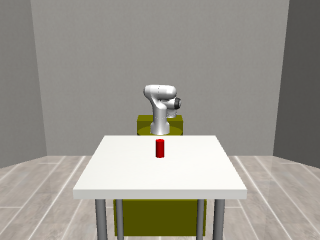

In [22]:
def get_image_of_pos(qpos, camera: str | int = "frontview"):
    """
    Position을 받아서 이미지를 반환하는 함수

    Args:
        qpos: joint position
        camera: camera name or index
    """
    data.qpos[qpos_adrs] = qpos
    # Path planner를 제작할 때는 mj_kinematics만 사용한다.
    mujoco.mj_kinematics(model, data)
    renderer.update_scene(data, camera=camera)
    return renderer.render()


media.show_image(get_image_of_pos(sample))

# Problem 2. `Collision Checker`

### In `data.contact`, we can see which `bodies` are in contact.

In [23]:
mujoco.mj_collision(model, data)

print(f"Contacted body counts: {data.ncon}")

for index in range(data.ncon):
    contact = data.contact[index]
    print(
        f'collision between "{contact.geom1} : {model.geom(contact.geom1).name}" and "{contact.geom2} : {model.geom(contact.geom2).name}"'
    )

Contacted body counts: 8
collision between "13 : object_collision" and "7 : table_collision"
collision between "15 : " and "48 : "
collision between "15 : " and "49 : "
collision between "15 : " and "50 : "
collision between "15 : " and "68 : "
collision between "15 : " and "77 : "
collision between "15 : " and "83 : "
collision between "15 : " and "86 : "


Because the `planner`interested in contact between
1. `robot`
2. `environment` within the `robot` itself

Ignores other contacts that would occur under ideal conditions where the robot would not collide.

In [24]:
ignore_pairs = [("object_collision", "table_collision")]

Implement a `CollisionChecker` class in `Python` to detect collisions in a `MuJoCo` simulation.

The collision checker should be able to handle specific pairs of geometries to ignore during collision detection and provide functionality to update the state of the model.

### **Specifications**:
#### 1. Class Definition:
- Class Name: `CollisionChecker`

#### 2. Constructor Parameters:
- `model`: An instance of `mujoco`.`MjModel` representing the `MuJoCo` model.
- `body_ids`: A list of `body IDs` to consider for collision checking.
- `ignore_pairs`: An optional list of tuples, each containing `two geometry names` to **ignore during collision detection.**

#### 3. Methods:
- `__init__(self, model: mujoco.MjModel, body_ids: list[int], ignore_pairs: list[tuple] = None)`: Initializes the collision checker with the given model, body IDs, and ignore pairs.
- `set_qpos(self, data: mujoco.MjData)`: Updates the internal state of the collision checker with the given simulation data.
- `__call__(self, sample: npt.NDArray, print_col: bool = False) -> bool`: Checks for collisions given a sample configuration and optionally prints collision details.

#### 4. Functional Requirements:
- The collision checker should update the model's configuration using the provided sample.
- Perform collision detection using MuJoCo's collision functions.
- Optionally ignore specified pairs of geometries during collision detection.
- Optionally print details of collisions if specified.
- Return a boolean indicating whether a collision was detected (excluding ignored pairs).

In [25]:
class CollisionChecker:
    def __init__(
        self,
        model: mujoco.MjModel,
        body_ids: list[int],
        ignore_pairs: list[tuple] = None,
    ) -> None:
        # Initialize the model
        self.model = model
        # Initialize the data for the simulation
        self.data = mujoco.MjData(model)
        # Get the joint positions associated with the body IDs
        self.qpos_adrs = get_qpos_adrs(model, body_ids)
        # Initialize the ignore flag
        self.ignore = False
        # If ignore pairs are provided
        if ignore_pairs:
            # Set the ignore flag to True
            self.ignore = True
            # Convert ignore pairs to sets of geometry IDs
            self.ignore_pairs = [
                set((model.geom(first).id, model.geom(second).id))
                for first, second in ignore_pairs
            ]

    def set_qpos(self, data: mujoco.MjData) -> None:
        self.data.qpos[:] = data.qpos.copy()

    def __call__(self, sample: npt.NDArray, print_col: bool = False) -> bool:
        # Set the joint positions to the given sample
        self.data.qpos[self.qpos_adrs] = sample

        # Perform kinematics computations
        mujoco.mj_kinematics(self.model, self.data)
        # Check for collisions
        mujoco.mj_collision(self.model, self.data)
        # Get the number of contacts
        number_of_contacts = self.data.ncon

        # Print collision details if requested
        if print_col:
            print(f"Contacted body counts: {number_of_contacts}")
            for contact in self.data.contact:
                print(
                    "Collied between",
                    f"{self.model.body(self.model.geom(contact.geom1).body).name} : {self.model.geom(contact.geom1).name} and",
                    f"{self.model.body(self.model.geom(contact.geom2).body).name} : {self.model.geom(contact.geom2).name}",
                )

        # If ignoring specific pairs of contacts
        if self.ignore:
            for contact in self.data.contact:
                pair = set((contact.geom1, contact.geom2))
                if pair in self.ignore_pairs:
                    number_of_contacts -= 1

        # Return True if there are any contacts, False otherwise
        return number_of_contacts != 0

In [43]:
collision = CollisionChecker(model, body_ids)
sample = sampler()
print(sample, not collision(sample, print_col=True))

Contacted body counts: 0
[-2.211 -0.231 -1.413 -1.005  0.733  1.591  2.704] True


## Kinematics

Use jacobian when doing inverse. In this case, `dof_adrs` must be used, because the qpos size of the free joint is 7, but the qvel size is 6. mujoco jacobian uses dof adrs because it deals with velocity values.
For reference, the total number of qpos is `model.nq` and the total number of qvel is `model.nv`.

In [27]:
def rot_to_omega(R, threshold):
    el = np.array([[R[2, 1] - R[1, 2]], [R[0, 2] - R[2, 0]], [R[1, 0] - R[0, 1]]])
    norm_el = np.linalg.norm(el)

    if norm_el > threshold:
        w = np.dot(np.arctan2(norm_el, np.trace(R) - 1) / norm_el, el)
    elif R[0, 0] > 0 and R[1, 1] > 0 and R[2, 2] > 0:
        w = np.zeros((3, 1))
    else:
        w = np.dot(np.pi / 2, np.array([[R[0, 0] + 1], [R[1, 1] + 1], [R[2, 2] + 1]]))

    return w


def calc_pose_error(target_pos, target_rot, current_pos, current_rot, threshold):
    pos_diff = target_pos - current_pos
    rot_diff = np.dot(current_rot.T, target_rot)
    w_err = np.dot(current_rot, rot_to_omega(rot_diff, threshold))
    return np.vstack((pos_diff.reshape([-1, 1]), w_err))


class Kinematics:
    def __init__(self, model: mujoco.MjModel, body_ids: list[int]) -> None:
        self.model = model
        self.body_ids = body_ids

    def forward(self, qpos: npt.NDArray, eef_id: int = None) -> npt.NDArray:
        body_ids = self.body_ids
        if eef_id:
            body_ids = self.get_sub_body_ids(eef_id)
        qpos_adrs = get_qpos_adrs(self.model, body_ids)
        if len(qpos_adrs) != len(qpos):
            raise ValueError(
                f"shape mismatch: qpos array of shape {qpos.shape} could not be broadcast to qpos addresses of shape ({len(qpos_adrs)},)"
            )

        fk_data = mujoco.MjData(self.model)
        fk_data.qpos[qpos_adrs] = qpos
        mujoco.mj_forward(self.model, fk_data)
        pos = fk_data.body(body_ids[-1]).xpos.copy()
        quat = fk_data.body(body_ids[-1]).xquat.copy()
        rot = fk_data.body(body_ids[-1]).xmat.reshape([3, 3]).copy()
        return pos, quat, rot

    def inverse(
        self,
        init_qpos: npt.NDArray,
        goal_pos: npt.NDArray,
        goal_rot: npt.NDArray,
        eef_id: int = None,
        max_iter: int = 10,
        threshold: float = 1e-8,
    ) -> npt.NDArray:
        body_ids = self.body_ids
        if eef_id:
            body_ids = self.get_sub_body_ids(eef_id)
        qpos_adrs = get_qpos_adrs(self.model, body_ids)
        if len(qpos_adrs) != len(init_qpos):
            raise ValueError(
                f"shape mismatch: qpos array of shape {init_qpos.shape} could not be broadcast to qpos addresses of shape ({len(qpos_adrs)},)"
            )
        # Jacobian address
        qvel_adrs = get_qvel_adrs(self.model, body_ids)

        dof = self.get_total_dof_of_body_ids(body_ids)
        nv = self.model.nv
        wn_pos = 1 / 0.3
        wn_ang = 1 / (2 * np.pi)
        We = np.diag([wn_pos, wn_pos, wn_pos, wn_ang, wn_ang, wn_ang])
        Wn = np.eye(dof)

        current_qpos = init_qpos.copy()
        ik_data = mujoco.MjData(self.model)
        ik_data.qpos[qpos_adrs] = current_qpos
        mujoco.mj_forward(self.model, ik_data)
        current_pos = ik_data.body(body_ids[-1]).xpos.copy()
        current_rot = ik_data.body(body_ids[-1]).xmat.copy().reshape([3, 3])
        err = calc_pose_error(goal_pos, goal_rot, current_pos, current_rot, threshold)
        Ek = np.dot(np.dot(err.T, We), err)[0][0]
        jacp = np.zeros((3, nv))
        jacr = np.zeros((3, nv))

        for _ in range(max_iter):
            lamb = Ek + 0.002
            mujoco.mj_jac(self.model, ik_data, jacp, jacr, current_pos, body_ids[-1])
            J = np.vstack(
                [
                    jacp[:, qvel_adrs[0] : qvel_adrs[0] + dof],
                    jacr[:, qvel_adrs[0] : qvel_adrs[0] + dof],
                ]
            )
            JT = np.dot(np.dot(J.T, We), J)
            J_dls = JT + np.dot(np.diag(np.diag(JT)), lamb)

            gerr = np.dot(np.dot(J.T, We), err)
            dq = np.dot(np.linalg.inv(J_dls), gerr)
            current_qpos += dq.reshape([-1])

            ik_data.qpos[qpos_adrs] = current_qpos
            mujoco.mj_forward(self.model, ik_data)
            current_pos = ik_data.body(body_ids[-1]).xpos.copy()
            current_rot = ik_data.body(body_ids[-1]).xmat.copy().reshape([3, 3])
            err = calc_pose_error(
                goal_pos, goal_rot, current_pos, current_rot, threshold
            )
            Ek2 = np.dot(np.dot(err.T, We), err)[0][0]
            if Ek2 <= threshold:
                break
            elif Ek2 < Ek:
                Ek = Ek2
            else:
                current_qpos -= dq.reshape([-1])
                break
        else:
            current_qpos = None
        return current_qpos

    def get_sub_body_ids(self, eef_id: int) -> list[int]:
        body_ids = [eef_id]
        body_id = eef_id
        for _ in range(self.model.nbody):
            parent_id = self.model.body(body_id).parentid
            body_ids.append(parent_id[0])
            body_id = body_ids[-1]
            if body_id == self.body_ids[0]:
                break
        else:
            raise ValueError(f"body {eef_id} not in tree of kinematics chain.")
        body_ids.reverse()
        return body_ids

    def get_total_dof_of_body_ids(self, body_ids: list[int]) -> int:
        dof = 0
        for jnt_id in self.model.body_jntadr[body_ids]:
            if jnt_id == -1:
                continue
            jnt_type = self.model.jnt(jnt_id).type
            if jnt_type[0] == mujoco.mjtJoint.mjJNT_FREE.value:
                dof += 7
            elif jnt_type[0] == mujoco.mjtJoint.mjJNT_BALL.value:
                dof += 4
            else:
                dof += 1
        return dof

In [60]:
kinematics = Kinematics(model, body_ids)

sample = sampler()
print(f"before: {sample}")

pos, _, rot = kinematics.forward(sample)
sample += np.random.normal(0, 0.1, sample.shape)

if sample in sampler:
    inversed = kinematics.inverse(sample, pos, rot)
    print(f"after:  {inversed}")
else:
    print("not in valid joint range")

before: [-1.658  1.659  2.056 -2.807  0.59   1.644  1.183]
after:  [-1.655  1.664  2.055 -2.808  0.587  1.647  1.187]


# Problem 3. `RRT* Planner`

Implement an `RRTStarPlanner` class in Python to find a collision-free path from an initial configuration to a goal configuration using the RRT* algorithm. The planner should be capable of sampling configurations, steering towards new configurations, checking for collisions, and rewiring the tree to ensure the minimum-cost path.

**Specifications**:

### 1. **Class Definition**:
- **Class Name**: `RRTStarPlanner`

### 2. **Constructor Parameters**:
- `gamma`: A parameter that influences the **radius**(= Boundary of neighborhood) of the search for nearby nodes during the rewiring process.
- `eta`: The maximum step size for the tree expansion.
- `epsilon`: Probability of sampling the goal configuration directly.
> `epsilon` 확률에 따라 random sample이 아닌 goal에 가까운 sampling point를 선택

### 3. **Methods**:
- `__init__(self, gamma: float, eta: float, epsilon: float = 0.0)`: Initializes the planner with the given parameters.
- `__call__(self, sampler: Sampler, collision: CollisionChecker, init_qpos: npt.NDArray, goal_qpos: npt.NDArray, max_iter: int = 1000, threshold: float = 0.5)`: Runs the RRT* algorithm to find a path from `init_qpos` to `goal_qpos`.
- `steer(self, nearest: npt.NDArray, sample: npt.NDArray, distance: float) -> npt.NDArray`: Steers from the nearest configuration towards the sample configuration within the step size limit.
- `path(self) -> list[npt.NDArray]`: Returns the found path as a list of configurations if a path has been found.

### 4. **Functional Requirements**:
- The planner should sample configurations from the configuration space and check for collisions.
- It should steer from the nearest node in the tree towards the sampled configuration, respecting the maximum step size.
- It should rewire the tree to ensure the minimum-cost path.
- It should handle both reaching the goal configuration and ensuring the path is within a specified threshold distance from the goal.


In [29]:
class RRTStarPlanner:
    def __init__(self, gamma: float, eta: float, epsilon: float = 0.0) -> None:
        # Initialize parameters
        self.gamma: float = gamma
        self.eta: float = eta
        self.epsilon: float = epsilon
        # Flag to check if path is ready,
        # [Initial -> Goal]이 가능한지 확인 하는 상태
        self.path_ready: bool = False

    def __call__(
        self,
        sampler: Sampler,
        collision: CollisionChecker,
        init_qpos: npt.NDArray,
        goal_qpos: npt.NDArray,
        max_iter: int = 1000,
        threshold: float = 0.5,
    ) -> None:
        # Initialize data buffers, tree structures
        self.samples = np.array([init_qpos.copy()])
        self.parents = np.array([-1], dtype=np.int32)
        self.costs = np.array([0], dtype=np.float64)

        self.path_ready = False

        # Main loop for the planner
        for _ in range(max_iter):
            # Sampling
            if np.random.random() < self.epsilon:
                ## 1. goal에 도달할 확률이 epsilon이하일 때, goal을 sampling
                new_qpos = goal_qpos.copy()
            else:
                ## 2. goal에 도달할 확률이 epsilon이상일 때, random sampling
                new_qpos = sampler()

            ## 3. sampling한 qpos가 valid한지 확인
            if collision(new_qpos):
                ## 4. collision이 발생하면 다시 sampling
                continue

            ## 5. nearest sample을 찾고, 새로운 sample로 steer
            distances = np.linalg.norm(self.samples - new_qpos, axis=1)

            nearest_node_index = np.argmin(distances)

            new_qpos = self.steer(
                self.samples[nearest_node_index],
                new_qpos,
                distances[nearest_node_index],
            )

            if new_qpos not in sampler:
                continue
            if collision(new_qpos):
                continue

            ## 6. 이웃한 node들을 찾아서, radius(cost)를 계산하고, 최소 radius(cost) 가지는 node를 near_indices에 저장
            # Connect along a minimum-cost path
            distances = np.linalg.norm(self.samples - new_qpos, axis=1)
            card = len(self.samples) + 1
            radius: float = self.gamma * (
                (math.log(card) / card) ** (1 / len(new_qpos))
            )
            radius: float = min(radius, self.eta)
            near_indices = np.where(np.around(distances, decimals=5) <= radius)[0]

            # Rewire the tree
            near_costs = distances[near_indices] + self.costs[near_indices]
            min_cost = np.min(near_costs)
            min_index = near_indices[np.argmin(near_costs)]
            self.samples = np.vstack((self.samples, new_qpos))
            self.parents = np.append(self.parents, min_index)
            self.costs = np.append(self.costs, min_cost)

            # Update all costs
            need_update = np.where(
                distances[near_indices] + min_cost < self.costs[near_indices]
            )[0]
            self.parents[need_update] = len(self.parents) - 1
            self.costs[need_update] = distances[need_update] + min_cost

        # Check if the goal is reached within the threshold
        distances = np.linalg.norm(self.samples - goal_qpos, axis=1)
        goal_near_indices = np.where(distances <= threshold)[0]
        if goal_near_indices.size > 0:
            index = np.argmin(
                self.costs[goal_near_indices] + distances[goal_near_indices]
            )
            cost = (
                self.costs[goal_near_indices[index]]
                + distances[goal_near_indices[index]]
            )
            self.samples = np.vstack((self.samples, goal_qpos.copy()))
            self.parents = np.append(self.parents, goal_near_indices[index])
            self.costs = np.append(self.costs, cost)
            self.path_ready = True

    def steer(
        self, nearest: npt.NDArray, sample: npt.NDArray, distance: float
    ) -> npt.NDArray:
        # Check if the nearest point is the same as the sample
        if np.equal(nearest, sample).all():
            return sample
        # Compute the vector towards the sample
        vector = sample - nearest
        # Normalize the vector
        unit_vector = vector / distance
        # Compute the step size
        step = min(self.eta, distance)
        # Compute the steered position
        steered = nearest + step * unit_vector

        return steered

    @property
    def path(self) -> list[npt.NDArray]:
        # Initialize path list
        path: list[npt.NDArray] = []

        # Check if the path is ready
        if self.path_ready:
            index = len(self.parents) - 1
            while index > 0:
                # Append the sample to the path
                path.append(self.samples[index])
                # Move to the parent index
                index = self.parents[index]
            # Reverse the path to start from the initial position
            path.reverse()

        return path

Start qpos


""

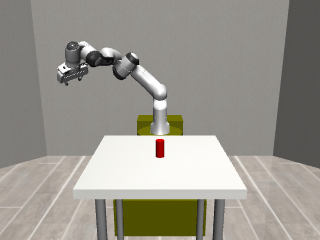

Goal qpos


""

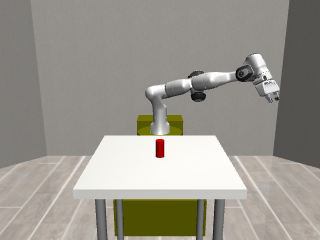

In [67]:
init_qpos = None
goal_qpos = None

while True:
    init_qpos = sampler()
    if not collision(init_qpos):
        break
while True:
    goal_qpos = sampler()
    if not collision(goal_qpos):
        break

print("Start qpos")
media.show_image(get_image_of_pos(init_qpos))

print("Goal qpos")
media.show_image(get_image_of_pos(goal_qpos))

In [68]:
planner_1 = RRTStarPlanner(gamma=0.5, eta=0.1, epsilon=0.1)
planner_2 = RRTStarPlanner(gamma=0.5, eta=0.05, epsilon=0.1)
planner_3 = RRTStarPlanner(gamma=0.5, eta=0.01, epsilon=0.1)

planners = [planner_1, planner_2, planner_3]
paths = []
for index, planner in enumerate(planners):
    start = time.time()
    planner(sampler, collision, init_qpos, goal_qpos, max_iter=10000, threshold=0.05)
    end = time.time()
    if path := planner.path:
        print(
            f"Planner {index+1} :: Find trajectory with length {len(path)} in time {end - start}."
        )
        paths.append(path)
    else:
        print(f"Planner {index+1} :: Failed to find trajectory. time: {end - start}")

Planner 1 :: Find trajectory with length 49 in time 2.338945150375366.
Planner 2 :: Find trajectory with length 95 in time 2.244891881942749.
Planner 3 :: Find trajectory with length 460 in time 2.409580945968628.


In [32]:
for path in paths:
    frames = [get_image_of_pos(path[0]) for _ in range(len(path) // 10)]
    frames = frames + [get_image_of_pos(pos) for pos in path]
    frames = frames + [get_image_of_pos(path[-1]) for _ in range(len(path) // 10)]

    media.show_video(frames, fps=len(path) / 5)

####  The video above was *__not__* controlled using a `PID controller`.

# Problem 4. `Cartesian Planner`

Implement a `CartesianPlanner` class in Python to find a collision-free path for a robotic end-effector from an initial pose to a goal pose. The planner should use inverse kinematics and collision checking to ensure the generated path is feasible and collision-free.

### **Specifications**:

#### 1. **Class Definition**:
- **Class Name**: `CartesianPlanner`

#### 2. **Constructor Parameters**:
- `damping`: A damping factor used in the `Damped Least Squares (DLS)` method for `inverse kinematics` (default: `0.01`).
- `goal_tolerance`: Tolerance for considering the goal position reached (default: `0.01`).

#### 3. **Methods**:
- `__init__(self, damping: float = 0.01, goal_tolerance: float = 0.01)`: Initializes the planner with the given parameters.
- `__call__(self, sampler: Sampler, collision: CollisionChecker, kinematics: Kinematics, init_qpos: npt.NDArray, goal_pos: npt.NDArray, goal_rot: npt.NDArray, eef_id: int = None, resolution: int = 1, n_step: int = 100, max_iter: int = 10, threshold: float = 1e-12)`: Plans a path from the initial configuration to the goal pose.
- `generate_waypoints(self, init_pos, init_rot, goal_pos, goal_rot, n_step, is_slerp=False) -> list[tuple[npt.NDArray, npt.NDArray]]`: Generates waypoints from the initial pose to the goal pose.

#### 4. **Functional Requirements**:
- The planner should generate waypoints from the initial pose to the goal pose.
- It should use inverse kinematics to move the end-effector along the waypoints.
- It should check for collisions and ensure the path is collision-free.
- It should stop if the goal pose is reached within the specified tolerance.

In [33]:
def get_quaternion_from_matrix(R):
    w = 1.0 / 2 * np.sqrt(R[0, 0] + R[1, 1] + R[2, 2] + 1)
    x, y, z = (
        1.0
        / 2
        * np.array(
            [
                np.sign(R[2, 1] - R[1, 2]) * np.sqrt(R[0, 0] - R[1, 1] - R[2, 2] + 1),
                np.sign(R[0, 2] - R[2, 0]) * np.sqrt(R[1, 1] - R[2, 2] - R[0, 0] + 1),
                np.sign(R[1, 0] - R[0, 1]) * np.sqrt(R[2, 2] - R[0, 0] - R[1, 1] + 1),
            ]
        )
    )
    return np.array([w, x, y, z])


def get_matrix_from_quaternion(quat):
    w, x, y, z = quat
    R = np.array(
        [
            [2 * (w**2 + x**2) - 1, 2 * (x * y - w * z), 2 * (x * z + w * y)],
            [2 * (x * y + w * z), 2 * (w**2 + y**2) - 1, 2 * (y * z - w * x)],
            [2 * (x * z - w * y), 2 * (y * z + w * x), 2 * (w**2 + z**2) - 1],
        ]
    )
    return R


def get_linear_interpolation(postionA, postionB, step):
    postionA = np.asarray(postionA)
    postionB = np.asarray(postionB)
    return postionB * step + postionA * (1 - step)


def get_quaternion_inverse(quaternion):
    q = np.array(quaternion, dtype=np.float64, copy=True)
    np.negative(q[1:], q[1:])
    return q / np.dot(q, q)


def get_quaternion_slerp(qA, qB, t):
    if isinstance(qA, (np.ndarray, list)) and isinstance(qB, (np.ndarray, list)):
        qA = np.asarray(qA)
        qB = np.asarray(qB)
        if qA.shape != (4,):  # quaternion
            raise ValueError("Expecting the shape of the orientation to be (4,)")
        if qB.shape == (0,):
            qB = np.asarray([1.0, 0.0, 0.0, 0.0])

        a = qB * get_quaternion_inverse(qA)
        result = np.sign(a) * (np.abs(a)) ** t * qA
        return result

In [34]:
class CartesianPlanner:
    def __init__(self, damping: float = 0.01, goal_tolerance: float = 0.01):
        # Initialize the damping factor to prevent numerical instability
        self.damping = damping
        # Initialize the tolerance for the goal position
        self.goal_tolerance = goal_tolerance
        # Initialize the path as an empty list
        self.path = []

    def __call__(
        self,
        sampler: Sampler,
        collision: CollisionChecker,
        kinematics: Kinematics,
        init_qpos: npt.NDArray,
        goal_pos: npt.NDArray,
        goal_rot: npt.NDArray,
        eef_id: int = None,
        resolution: int = 1,
        n_step: int = 100,
        max_iter: int = 10,
        threshold: float = 1e-12,
    ) -> None:
        # Reset the path
        self.path = []

        # Get the initial position and orientation using forward kinematics
        init_pos, _, init_rot = kinematics.forward(init_qpos, eef_id)

        # Generate waypoints from the initial to the goal position and orientation
        waypoints = self.generate_waypoints(
            init_pos, init_rot, goal_pos, goal_rot, n_step
        )

        # Initialize necessary variables and addresses for joint positions and velocities
        nv = kinematics.model.nv
        body_ids = kinematics.body_ids
        joint_ids = kinematics.model.body_jntadr[body_ids]
        joint_ids = [id for id in joint_ids if id != -1]
        qpos_adrs = kinematics.model.jnt_qposadr[joint_ids]
        qvel_adrs = kinematics.model.jnt_dofadr[joint_ids]
        jac_data = mujoco.MjData(kinematics.model)
        jac_data.qpos[:] = collision.data.qpos.copy()
        jacp = np.zeros((3, nv))
        jacr = np.zeros((3, nv))
        dof = kinematics.get_total_dof_of_body_ids(body_ids)

        # Initialize collision flag and damping factor
        collision_flag = False
        damping = self.damping
        for _ in range(max_iter):
            # Initialize the current joint positions
            # Perform forward kinematics to update the current position and orientation
            current_qpos = init_qpos.copy()
            joint_path = [current_qpos]
            jac_data.qpos[qpos_adrs] = current_qpos
            mujoco.mj_forward(kinematics.model, jac_data)
            current_pos = jac_data.body(body_ids[-1]).xpos.copy()
            current_rot = jac_data.body(body_ids[-1]).xmat.copy().reshape([3, 3])

            for step, (pos, rot) in enumerate(waypoints):
                # Calculate the pose error between the current and target positions and orientations
                err_pose = calc_pose_error(
                    pos, rot, current_pos, current_rot, threshold
                )
                # Compute the Jacobian for the end effector
                mujoco.mj_jac(
                    kinematics.model, jac_data, jacp, jacr, current_pos, body_ids[-1]
                )
                # Compute the damped least squares (DLS) solution for the inverse kinematics problem
                J = np.vstack(
                    [
                        jacp[:, qvel_adrs[0] : qvel_adrs[0] + dof],
                        jacr[:, qvel_adrs[0] : qvel_adrs[0] + dof],
                    ]
                )
                J_dls = np.dot(
                    J.T, np.linalg.inv(np.dot(J, J.T) + damping**2 * np.identity(6))
                )
                # Update the current joint positions
                dq = np.dot(J_dls, err_pose)
                current_qpos = current_qpos + dq.reshape([-1])

                # Check for collisions at the new joint positions
                if collision(current_qpos):
                    collision_flag = True
                    break

                # Update the joint positions in the Jacobian data and perform forward kinematics
                jac_data.qpos[qpos_adrs] = current_qpos
                mujoco.mj_forward(kinematics.model, jac_data)
                current_pos = jac_data.body(body_ids[-1]).xpos.copy()
                current_rot = jac_data.body(body_ids[-1]).xmat.copy().reshape([3, 3])

                # Check if the current position is within the sample space
                if current_qpos in sampler:
                    if step % (1 / resolution) == 0 or step == len(waypoints) - 1:
                        joint_path.append(current_qpos)
            else:
                # Check if the final position is within the goal tolerance
                err = np.linalg.norm(goal_pos - current_pos)
                if err < self.goal_tolerance:
                    break
            if collision_flag:
                # Clear the joint path if a collision was detected
                joint_path = []
                break
        else:
            # Clear the joint path if the maximum number of iterations was reached without success
            joint_path = []
        # Set the path to the computed joint path
        self.path = joint_path

    def generate_waypoints(
        self, init_pos, init_rot, goal_pos, goal_rot, n_step, is_slerp=False
    ) -> list[tuple[npt.NDArray, npt.NDArray]]:
        # Initialize waypoints list
        waypoints = []
        # Check if spherical linear interpolation (slerp) is needed
        if is_slerp:
            init_ori = get_quaternion_from_matrix(init_rot)
            goal_ori = get_quaternion_from_matrix(goal_rot)

        for step in range(1, n_step + 1):
            # Compute the interpolation factor
            delta_t = step / n_step
            # Compute the linear interpolation for position
            pos = get_linear_interpolation(init_pos, goal_pos, delta_t)
            rot = init_rot
            # Compute the slerp for rotation if needed
            if is_slerp:
                quat = get_quaternion_slerp(init_ori, goal_ori, delta_t)
                rot = get_matrix_from_quaternion(quat)
            # Append the interpolated position and rotation to the waypoints
            waypoints.append((pos, rot))
        return waypoints

Init qpos


""

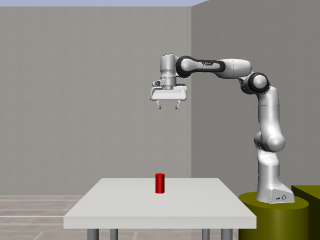

In [35]:
mujoco.mj_resetDataKeyframe(model, data, key)
mujoco.mj_forward(model, data)

init_qpos = data.qpos[qpos_adrs]

print("Init qpos")
media.show_image(get_image_of_pos(init_qpos, "sideview"))

cartesian_goals = []
for axis in range(3):
    goal_pos, _, goal_rot = kinematics.forward(init_qpos)
    goal_pos[axis] = goal_pos[axis] - 0.1
    cartesian_goal_qpos = kinematics.inverse(init_qpos, goal_pos, goal_rot)
    if cartesian_goal_qpos is not None and cartesian_goal_qpos in sampler:
        cartesian_goals.append((goal_pos, goal_rot))

## Final term project - grasp red object using PID controller & path planning method

1. Find optimized path for grasping the object
2. Control robotic arm using PID strategy

In [36]:
planner = CartesianPlanner()

paths = []
axis_name = ["X", "Y", "Z"]

for index, (pos, rot) in enumerate(cartesian_goals):
    start = time.time()
    planner(sampler, collision, kinematics, init_qpos, pos, rot, n_step=100)
    end = time.time()

    if path := planner.path:
        print(
            f"Path to move {axis_name[index]}-axis :: Find trajectory with length {len(path)} in time {end - start}."
        )
        paths.append(path)
    else:
        print(
            f"Path to move {axis_name[index]}-axis :: Failed to find trajectory. time: {end - start}"
        )

Path to move X-axis :: Find trajectory with length 101 in time 0.08336901664733887.
Path to move Y-axis :: Find trajectory with length 101 in time 0.07396602630615234.
Path to move Z-axis :: Find trajectory with length 101 in time 0.012079000473022461.


In [39]:
views = ["sideview", "frontview", "frontview"]

for path, view in zip(paths, views):
    frames = [get_image_of_pos(path[0], view) for _ in range(len(path) // 10)]
    frames = frames + [get_image_of_pos(pos, view) for pos in path]
    frames = frames + [get_image_of_pos(path[-1], view) for _ in range(len(path) // 10)]

    media.show_video(frames, fps=len(path) / 5)

The video above was *__not__* controlled using a PID controller.